## PROYECTO FINAL IA, SIC

## GRUPO CONFORMADO POR:


### STEVEN AMPIE GRUPO #5
### VIVIANA DAVIS GRUPO #6
### ENRIQUE QUERINI GRUPO #6
### JOHAN PIMENTEL GRUPO #3
### ALEXANDER SANTAMARIA GRUPO #6

 ##### Buscar en Telegram el bot @AttentionFoodBot  (Primero correr el codigo)
 
 
 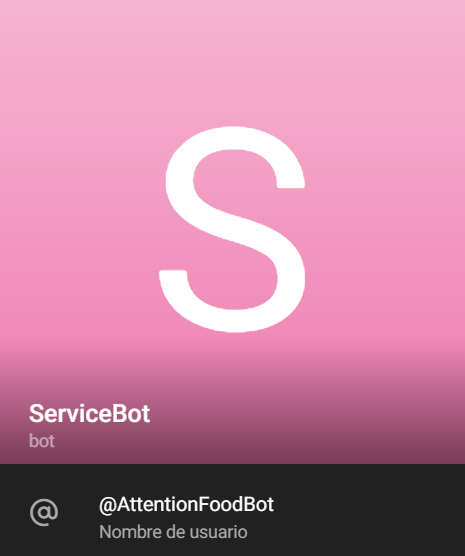

In [2]:

#importamos las librerias a utilizar

import tensorflow 
import numpy as np
import tflearn
import nltk
import json
import random
import pickle
import threading   
import telebot
from tokenizer import *
from nltk.stem.lancaster import LancasterStemmer
stemmer=LancasterStemmer()

In [3]:

#Abrimos el archivo Json con los datos a utilizar

with open("Data.json", encoding='utf-8') as files:
    datos=json.load(files)


In [4]:
#Lo siguiente crea un archivo Pickle guardando nuestras variables utilizadas. Ak mismo tiempo se tratan los datos.


try:
    with open("Vars.pickle","rb") as FilePickle_new:
        Words, tags, Train, output = pickle.load(FilePickle_new)  

except:
    Words=[]
    tags=[]
    AuxX=[]
    AuxY=[]


    nltk.download('punkt') #En algunos casos no descargar esto, genera un error, por lo tanto es bueno descargarlo 
                           #si aun no se descarga



    for contenido in datos["contenido"]:
        for patrones in contenido["patrones"]:
                AuxPalabra=nltk.word_tokenize(patrones) 
                Words.extend(AuxPalabra)
                AuxX.append(AuxPalabra)
                AuxY.append(contenido["tag"])
                if contenido["tag"] not in tags:
                    tags.append(contenido["tag"])


    Words=[stemmer.stem(w.lower()) for w in Words if w!= "?"]

    Words=sorted(list(set(Words)))
    tags=sorted(tags)

    Train=[]
    output=[]
    Exit_Empty=[0 for _ in range(len(tags))]




    for x, document in enumerate(AuxX):
            bucket=[]
            AuxPalabra=[stemmer.stem(w.lower()) for w in document]
            for w in Words:
                if w in AuxPalabra:
                    bucket.append(1)
                else:
                    bucket.append(0)
            exit=Exit_Empty[:]
            exit[tags.index(AuxY[x])]=1
            Train.append(bucket)
            output.append(exit)
            


    Train=np.array(Train)
    output=np.array(output)
    with open("Vars.pickle", "wb") as archivoPickle:
        pickle.dump((Words, tags,Train, output ), archivoPickle )


In [5]:

#Construccion del modelo

red=tflearn.input_data(shape=[None,len(Train[0])])
red=tflearn.fully_connected(red, len(output))
red=tflearn.fully_connected(red,len(output))
red=tflearn.fully_connected(red,len(output[0]), activation="softmax") 
red=tflearn.regression(red)

modelo=tflearn.DNN(red)
try:
     modelo.load("modelo.tflearn")

except:
    
     modelo.fit(Train, output, n_epoch=1000, batch_size=len(output), show_metric=True)
     modelo.save("modelo.tflearn")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from c:\Users\Steven\Desktop\BotT-main\BotT-main\modelo.tflearn


In [6]:
#herramientas para funciones con la api de Telegram


total=0
pedidos=[]
menu = {"/polloasado": 7.50,
        "/pizza": 12.50,
        "/soda": 1.25,
        "/hamburguesa": 5.50,
        "/jugoNaranja": 1.25,
        "/papas": 4.75,
        "/sushi": 7.25,
        "/teFrio": 1.25}
cuentaActual = '' 

In [7]:
# Creacion de las funciones y comandos con lo que el bot trabajara

bot=telebot.TeleBot(BotToken)


#funcion para terminar el pedido

@bot.message_handler(commands=["end"])
def cmd_finish(message):
    comando_final=message.text
    global menu
    global total
    global pedidos
    if comando_final == "/end":
        for food in pedidos:
            bot.send_message(message.chat.id, f'--- {food[1:]} :  {menu[food]} $')
        bot.send_message(message.chat.id, f'Su total es de: {total} $')
        total=0
        pedidos=[]



#Funcion para obtener el menu

@bot.message_handler(commands=["orden"])
def cmd_orden(message):
     bot.send_message(message.chat.id, "Nuestros productos son los siguientes: \n\n/polloasado: 7.50$, \n/pizza: 12.50$, \n/soda: 1.25$, \n/hamburguesa: 5.50$, \n/jugoNaranja: 1.25$, \n/papas: 4.75$, \n/sushi: 7.25$, \n/teFrio: 1.25$")
     



# Funcion para seleccionar una comida y agregarla a tu orden 

@bot.message_handler(commands=["polloasado", "pizza", "soda", "hamburguesa", "jugoNaranja", "papas", "sushi", "teFrio"])
def cmd_food(message):

     comandos=["/polloasado", "/pizza", "/soda", "/hamburguesa", "/jugoNaranja", "/papas", "/sushi", "/teFrio"]
     global pedidos
     global total
     global cuentaActual
     comando=message.text
     if comando in comandos:
        pedidos.append(comando)
        total+=menu[comando]

        bot.send_message(message.chat.id, f'listo tu orden ha sido añadida, para dejar de ordenar aplica el comando: /end. \n\nSu cuenta hasta el momento es de: {total} $\n\n\n Digame que mas puedo añadir a su cuenta: \n/polloasado: 7.50$, \n/pizza: 12.50$, \n/soda: 1.25$, \n/hamburguesa: 5.50$, \n/jugoNaranja: 1.25$, \n/papas: 4.75$, \n/sushi: 7.25$, \n/teFrio: 1.25$')

        bot.send_message(message.chat.id, f'Menu actual:')
        cuentaActual = ''
        for food in pedidos:
            cuentaActual += f'--- {food[1:]} :  {menu[food]} $ --- eliminar - /{food[1:]}Eli \n'
        
        bot.send_message(message.chat.id, f'{ cuentaActual }')


#Funcion para eliminar algun producto


@bot.message_handler(commands=["polloasadoEli", "pizzaEli", "sodaEli", "hamburguesaEli", "jugoNaranjaEli", "papasEli", "sushiEli", "teFrioEli"])
def cmd_foodDelete(message):

     global pedidos
     global total
     global cuentaActual
     comando=message.text
     comando = comando.split("Eli")[0]
     if comando in pedidos:
        pedidos.remove(comando)
        total -= menu[comando]
    
        bot.send_message(message.chat.id, f'Tu pedido ha sido eliminado, para dejar de ordenar aplica el comando: /end. \n\nSu cuenta hasta el momento es de: {total} $\n\n\n Digame que mas puedo añadir a su cuenta: \n/polloasado: 7.50$, \n/pizza: 12.50$, \n/soda: 1.25$, \n/hamburguesa: 5.50$, \n/jugoNaranja: 1.25$, \n/papas: 4.75$, \n/sushi: 7.25$, \n/teFrio: 1.25$')

        bot.send_message(message.chat.id, f'Menu actual:')
        cuentaActual = ''
        for food in pedidos:
            cuentaActual += f'--- {food[1:]} :  {menu[food]} $ --- eliminar - /{food[1:]}Eli \n'
        
        bot.send_message(message.chat.id, f'{ cuentaActual }')

     



#Funcion para que el bot reconozca lo que el usuario a escrito

@bot.message_handler(content_types=["text"])
def mainBot(message):
        
        #funcion del procesamiento del lenguaje natural y respuesta acorde al modelo entrenado

        message_new=message 
        mensaje=message_new.text


        bucket=[0 for _ in range(len(Words))]
        Output_Processing=nltk.word_tokenize(mensaje)
        Output_Processing=[stemmer.stem(palabra.lower()) for palabra in Output_Processing]
        for single_word in Output_Processing:
            for i, palabra in enumerate(Words):
                if palabra == single_word:
                    bucket[i]=1
        resultados=modelo.predict([np.array(bucket)])
        
        resultadosIndices=np.argmax(resultados)
        tag=tags[resultadosIndices]


        for tagAux in datos["contenido"]:
            if tagAux["tag"] == tag:
                    respuesta=tagAux["respuestas"]
                    respuesta_alzar=random.choice(respuesta)
        if max(bucket) == 0:
            bot.send_message(message.chat.id,'No entiendo lo que dices')
            bot.send_message(message.chat.id, "Para conocer nuestros comandos para ordenar, escribe el comando, /orden ")
        else:
            bot.send_message(message.chat.id,respuesta_alzar)
            bot.send_message(message.chat.id, "Para conocer nuestros comandos para ordenar, escribe el comando, /orden ")




In [8]:
#mantener el bot activo
def iniciar_bot():
    bot.infinity_polling()

In [9]:
# MAIN 

if __name__ == '__main__':
    print('iniciando el bot')
    inicio=threading.Thread(name="inicio", target=iniciar_bot)
    inicio.start()
    print('El bot se ha iniciado')

iniciando el bot
El bot se ha iniciado
